In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import random
import itertools
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec

from tqdm import *

import keras
from keras.applications import *
import lightgbm as lgbm


Using TensorFlow backend.


In [2]:
from astrohack import *
import astrohack

In [3]:
x = 128+16+4
if x & 16:
    print("a")

a


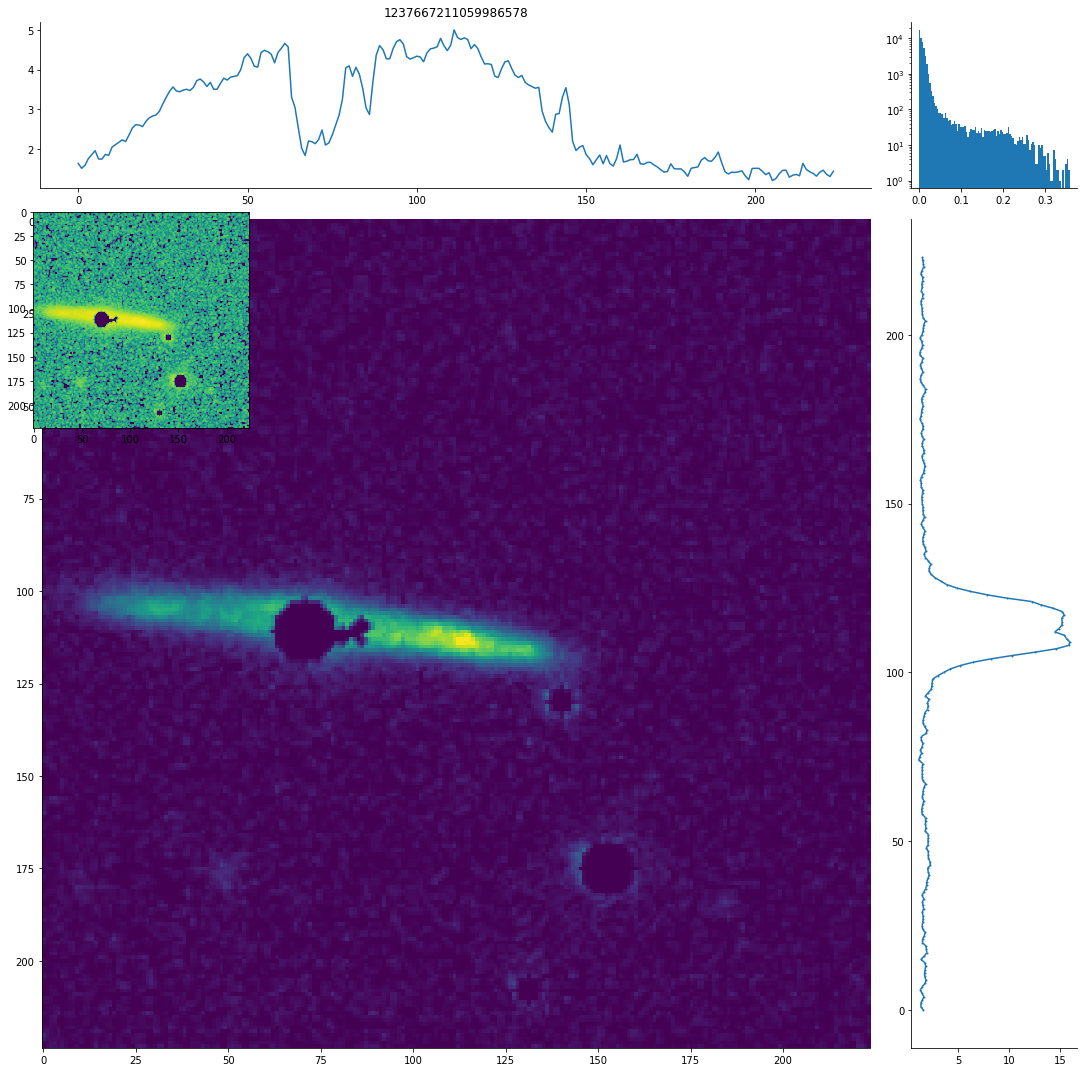

In [4]:
astrohack.dataFolder = 'data/mainData/'
astrohack.dataFolder = 'data/mainData_original/'

X = read_image('1237667211059986578')
X = cleanupImage(X)
X = img_preprocnoread(X, 1) 
X = img_preproc('1237667211059986578',79)
# plt.imshow(img_preproc('1237667211059986578', 16+32+64))
# plt.show()
# 1 for vlip
# 2 for hflip
# 4 for rotate90
# 8 for scale[0,1]
# 16 for log1p
# 32  for normalize ([-mean/std])
# 64 for crop
# 128 hackaton cleanup

drawOneGalaxy(1237667211059986578,128+16+4+2)

# score = xi2(truth, pred, error)



### Read metadata file

In [5]:
df = getAstrohackDataFrame()

df.head()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,ML_g,ML_i,ML_g_rel_err,ML_i_rel_err,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile
174,1237662301367173202,231.31860,41.34601,0.512861,0.0761,48.655727,326.142854,0.632474,2.472975,2.279201,0.105385,0.10490392881262686,10.325,0.045,326.142854,2.113489e+10,2.189920e+09,True
216,1237662301905813735,236.00985,39.28830,0.446684,0.0685,38.145197,293.571417,0.569310,0.841365,1.148099,0.093758,0.09498951605786418,9.824,0.040,293.571417,6.668068e+09,6.141517e+08,True
237,1237662534360301834,237.49500,9.27861,0.630957,0.0390,30.677076,167.142861,0.324133,0.703785,1.051369,0.122754,0.12327084107474802,9.923,0.053,167.142861,8.375293e+09,1.022096e+09,True
276,1237662500543987740,242.00880,36.05398,0.562341,0.0658,46.129129,282.000016,0.546870,1.248502,1.269311,0.183377,0.1837691489095808,10.356,0.079,282.000016,2.269865e+10,4.128980e+09,True
332,1237662474232398001,246.28905,29.94774,0.446684,0.0455,25.337321,194.999996,0.378155,0.419816,0.559744,0.219920,0.2194701990290622,9.234,0.094,194.999996,1.713957e+09,3.709741e+08,True


In [6]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.fig = plt.figure()
        self.logs = []
        self.lr = []
        
    def on_train_begin(self, logs={}):
        self.initVars()
        self.referenceLoss = xi2(self.referencePrediction, data[TEST+TRUTH], data[TEST+ERROR])

    def on_epoch_end(self, epoch, logs={}):
        
        self.i += 1
        
        curloss = logs.get('loss')
        self.losses.append(curloss)
        self.val_losses.append(logs.get('val_loss'))
        self.logs.append(logs)
        self.x.append(self.i)
        
        clear_output(wait=True)
        plt.figure(figsize=(6,6))

    def plotLosses(self, ax):
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="val loss")
        ax.set_yscale("log", nonposy='clip')
        plt.legend()
        
plot_losses = PlotLosses()

In [7]:
df

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,ML_g,ML_i,ML_g_rel_err,ML_i_rel_err,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile
174,1237662301367173202,231.31860,41.34601,0.512861,0.0761,48.655727,326.142854,0.632474,2.472975,2.279201,0.105385,0.10490392881262686,10.325,0.045,326.142854,2.113489e+10,2.189920e+09,True
216,1237662301905813735,236.00985,39.28830,0.446684,0.0685,38.145197,293.571417,0.569310,0.841365,1.148099,0.093758,0.09498951605786418,9.824,0.040,293.571417,6.668068e+09,6.141517e+08,True
237,1237662534360301834,237.49500,9.27861,0.630957,0.0390,30.677076,167.142861,0.324133,0.703785,1.051369,0.122754,0.12327084107474802,9.923,0.053,167.142861,8.375293e+09,1.022096e+09,True
276,1237662500543987740,242.00880,36.05398,0.562341,0.0658,46.129129,282.000016,0.546870,1.248502,1.269311,0.183377,0.1837691489095808,10.356,0.079,282.000016,2.269865e+10,4.128980e+09,True
332,1237662474232398001,246.28905,29.94774,0.446684,0.0455,25.337321,194.999996,0.378155,0.419816,0.559744,0.219920,0.2194701990290622,9.234,0.094,194.999996,1.713957e+09,3.709741e+08,True
348,1237662474235085097,251.31645,25.60003,0.512861,0.0681,43.540800,291.857134,0.565985,1.100280,1.303210,0.100101,0.10133412294019577,10.001,0.042,291.857134,1.002305e+10,9.693151e+08,True
361,1237662337873412483,255.44295,21.26792,0.724436,0.0491,44.343589,210.428573,0.408075,2.667584,2.233701,0.187117,0.16947816439336486,10.311,0.065,210.428573,2.046445e+10,3.062873e+09,True
1416,1237662303518851247,242.24295,36.61078,1.995262,0.0301,74.871368,128.999996,0.250164,2.754989,2.115957,0.102072,0.09329305060938459,10.912,0.017,128.999996,8.165824e+10,3.196426e+09,True
1436,1237662504296120502,244.38855,31.57755,0.870964,0.0223,24.213311,95.571426,0.185337,0.767558,1.552294,0.071779,0.07917758724371973,9.421,0.030,95.571426,2.636331e+09,1.821113e+08,True
1779,1237662305111834638,203.53710,39.85028,0.676083,0.0474,39.951001,203.142863,0.393946,2.504886,2.299402,0.073700,0.08137116373854937,10.197,0.030,203.142863,1.573983e+10,1.087269e+09,True


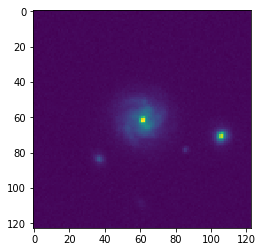

In [11]:
plt.imshow(x)
plt.show()

In [34]:
curIDX = 22

(6272,)

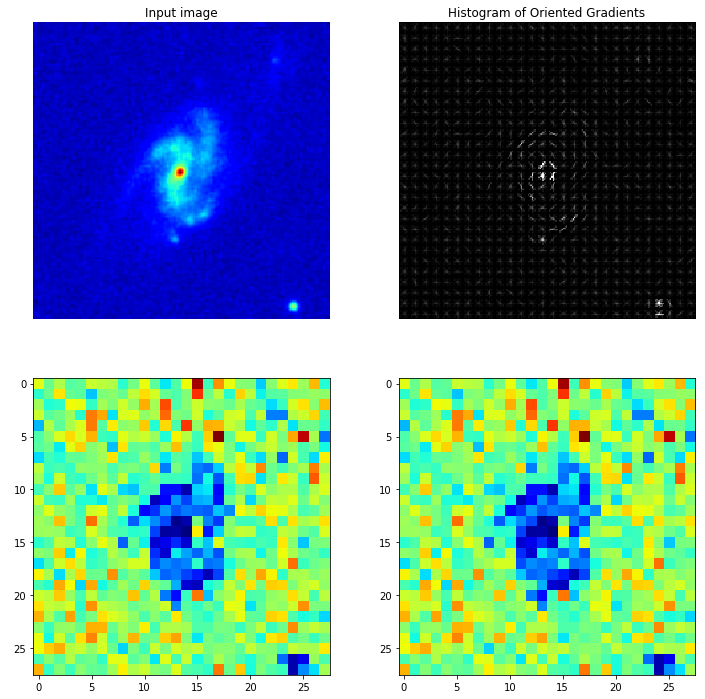

In [136]:
import skimage
from skimage.feature import hog
from skimage import data, color, exposure



curIDX = curIDX+1
x = read_image(df.SDSS_ID.values[curIDX])
x = img_preproclist(x, [PP_LOG1P, 0])
# x[0:16,0:16] = np.zeros((16,16))

fd, hog_image = hog(x, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(1, 1), visualise=True, block_norm='L2-Hys')

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)


plt.figure(figsize=(12,12))
ax1 = plt.subplot(221)
ax1.axis('off')
ax1.imshow(x, cmap='jet')
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

ax2 = plt.subplot(222)
# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))


ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box-forced')


ax2 = plt.subplot(223)

fdr = fd.reshape((28,28,8))

plt.imshow(abs(fdr).mean(axis=2), cmap='jet')

ax2 = plt.subplot(224)

plt.imshow(abs(fdr).sum(axis=2), cmap='jet')

fd.shape

In [88]:
fdr = fd.reshape((28,28,8))

plt.imshow(abs(fdr).mean(axis=2))
plt.show()
plt.ion()

np.max(fd)

144.46663614754812

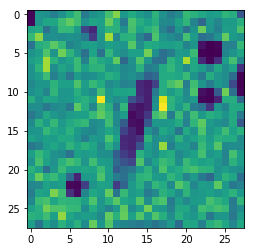